# Code Sandbox

A place to test new code and functions

In [12]:
# import packages and set working directory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from math import exp
#os.chdir('../maize-Toff')

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel

In [2]:
climate = Climate()

soil = Soil(texture='loam')
crop = Crop(soil=soil)
soil.set_nZr(crop)

225.5

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b9c9b50>]],
      dtype=object)

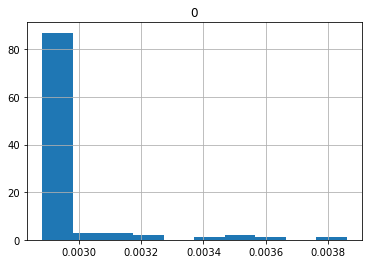

In [22]:
n_sim = 100
models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]

planting_date = 10

output = [model.run(do_output=True, s0=0.3, planting_date=planting_date) for model in models]

s_avg = pd.DataFrame([o['s'].mean() for o in output])
s_avg.hist()

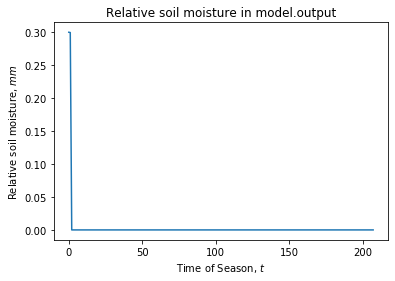

In [20]:
# Plot Time Series

def plot_ts(x, title, ylab):
    #d = np.arange(181)
    plt.plot(x, '-')
    plt.title(title)
    plt.xlabel('Time of Season, $\mathit{t}$')
    plt.ylabel(ylab)

# S and time
o = model.output()
plot_ts(o['s'], 'Relative soil moisture in model.output', 'Relative soil moisture, $\mathit{mm}$')